Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 95, 127, 16)       80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 93, 125, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 62, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 62, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 91264)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5840960   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

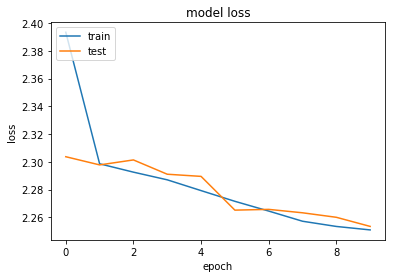

Score log_loss:  2.30321008619


In [1]:
from sklearn.datasets import load_files
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import numpy as np
from glob import glob
import random
import cv2
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt     
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import log_loss
from keras import optimizers
import math
import pickle
import os
import pandas as pd
import datetime

def model_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def create_submission(predictions, test_id, loss):
    print('Started building csv file')
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.insert(loc=0, column='img', value=test_id)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = str(round(loss, 6)) + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)
    print("successfully created submission")   
    
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()

def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def read_imc(path):
    # Load as grayscale
    #img = cv2.imread(path, 0)
    # Reduce size
    #resized = cv2.resize(img, (224, 224))
    #x = image.img_to_array(path)
    #resized=np.expand_dims(x, axis=0)
    img = cv2.imread(path,0)
    img_rows, img_cols=96,128
   # resized = cv2.resize(img, (96, 128), cv2.INTER_LINEAR)
    resized = cv2.resize(img, (img_rows, img_cols))
    return resized

def get_driver_data():
    dr = dict()
    clss = dict()
    path ='Data/driver_imgs_list.csv'
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
        if arr[0] not in clss.keys():
            clss[arr[0]] = [(arr[1], arr[2])]
        else:
            clss[arr[0]].append((arr[1], arr[2]))
    f.close()
    return dr, clss

def load_train():
    #path='Data/imgs/train'
    #data=load_files(path)
    #driver_file=np.array(data['filenames'])
    #driver_target=np_utils.to_categorical(np.array(data['target']),10)
    #data=glob(path)
    driver_file=[]
    driver_target=[]
    driver_id=[]
    driver_file_id=[]
    driver_data, dr_class = get_driver_data()
    print('driver data and class sample',len(driver_data),len(dr_class))
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'Data', 'imgs', 'train', 'c' + str(j), '*.jpg')
        data = glob(path)
        for p in data:
            
            driver_file.append(read_imc(p))
            driver_target.append(j)
            base = os.path.basename(p)
            driver_file_id.append(base)
            driver_id.append(driver_data[base])
            print(driver_data[base])
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return driver_file,driver_target,driver_file_id,driver_id,unique_drivers

def load_test():
    path='Data/imgs/test/*'
    data=glob(path)
    driver_file=[]
    driver_id=[]  
    for p in data:
        driver_file.append(read_imc(p))
        driver_id.append(os.path.basename(p))
        
   # driver_id=os.path.basename(p)
    #test_id=np.array(driver_file['target'])
    return driver_file,driver_id


def print_sample(data,target):
    print ("X shape",data.shape) 
    print ("Y shape",target.shape)
    
   # for p in data[:2]: print (p)
  #  for p in target[:2]: print (p)
    #im = cv2.imread(data[1])
    # show sample image   
    #plt.imshow(im)
    #plt.show()
    return None

def get_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
   
    for i in range(len(train_data)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
            
    data = np.array(data)
    target = np.array(target)
    print('driver list length',len(driver_list))
    return data, target


def data_split(data,target,test_size,driver_id,driver_list):
 #   if unique==True:
        
       # perm = np.random.permutation(len(target))
        #x,y = data[perm], target[perm]
        #unique_list_train = [unique_drivers[i] for i in train_drivers]
        
        #drivers_list=drivers_list[perm]
        random.shuffle(driver_list)
        #test_size=0.2
        test_split=test_size*len(driver_list)
        test_split=int(round(test_split))
       
        train_list=driver_list[test_split:]
        test_list=driver_list[:test_split]
        
        X_train,y_train = get_selected_drivers(data,target,driver_id,train_list)
        X_test,y_test = get_selected_drivers(data,target,driver_id,test_list)
        
        perm = np.random.permutation(len(y_train))
        X_train,y_train = X_train[perm], y_train[perm]
        
        perm = np.random.permutation(len(y_test))
        X_test,y_test = X_test[perm], y_test[perm]
        
        print('Train shape',train_list )
        print('Test shape',test_list)

  #  else:    
   #     X_train, X_split, y_train, y_split = train_test_split(data,target,test_size=test_size,random_state=42)
    
        return X_train, X_test, y_train, y_test, test_list

img_rows=96
img_cols=128
img_channel=1  

model = Sequential()
  
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=(img_rows,img_cols,1)))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(10, activation='softmax'))

model.summary()

#model.compile(loss='categorical_crossentropy', optimizer='adadelta',metrics=['accuracy'])
#sgd = optimizers.SGD(lr=7e-3, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.000001)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
#tried sgd,rmsprop
#adagrad,adamax



cache_path= os.path.join('cache','test.dat')
if not os.path.isfile(cache_path):
    print('building test cache')
    test_files,test_id = load_test()
    cache_data((test_files,test_id),cache_path)
    print('test cache built')
else:
    print('Restore test from cache')
    (test_files,test_id)=restore_data(cache_path)

    
#test_files=test_files[:100]
#test_id=test_id[:100]
test_files=np.array(test_files,dtype=np.uint8)
test_files = test_files.reshape(test_files.shape[0], img_rows, img_cols,img_channel)
#test_files=test_files[:1000]
#test_id=test_id[:1000]


#submission training set
cache_path= os.path.join('cache','train.dat')
if not os.path.isfile(cache_path):
    print('building train cache')
    train_files,train_targets,train_id, driver_id, unique_drivers = load_train()
    cache_data((train_files,train_targets,train_id, driver_id, unique_drivers),cache_path)
    print('train cache built')           
else:
    print('Restore train from cache')
    (train_files,train_targets,train_id, driver_id, unique_drivers)=restore_data(cache_path)


train_files=np.array(train_files,dtype=np.uint8)
train_targets=np.array(train_targets,dtype=np.uint8)

train_files = train_files.reshape(train_files.shape[0], img_rows, img_cols,img_channel)

train_targets=np_utils.to_categorical(train_targets,10)

train_files = train_files.astype('float32')
train_files/=255

test_size=0.3
X_train, X_split, y_train, y_split,split_driver_list =data_split(train_files,train_targets,test_size,driver_id,unique_drivers)
#X_train, X_split, y_train, y_split = train_test_split(train_files,train_targets ,test_size=0.2,random_state=42)
test_size=0.4
X_test, X_val, y_test, y_val,val_driver_list = data_split(X_split,y_split,test_size,driver_id,split_driver_list)
#X_test, X_val, y_test, y_val = train_test_split(X_split,y_split ,test_size=0.3,random_state=42)
#print('Dataset shape'.train_files.shape)
print('Train shape',X_train.shape )
print('Test shape',X_test.shape )
print('Val shape',X_val.shape )


train_datagen=ImageDataGenerator(
   #rescale=1./255,
   #shear_range=0.2,
   zoom_range=0.2,
   width_shift_range=0.1,
   height_shift_range=0.1, 
   horizontal_flip=True
    
    )

val_datagen=ImageDataGenerator(
   zoom_range=0.2,
   width_shift_range=0.1,
   height_shift_range=0.1, 
   horizontal_flip=True
    )

train_datagen.fit(X_train)
val_datagen.fit(X_val)

### TODO: Define your architecture.


#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
checkpointer = ModelCheckpoint(filepath='saved_models/weightsfromscratch.hdf5', 
                               verbose=1, save_best_only=True)
epochs=10
batch_size=64
history=model.fit_generator(train_datagen.flow(X_train,y_train,batch_size=batch_size),
                            validation_data=val_datagen.flow(X_val,y_val),
                    steps_per_epoch=len(X_train)/batch_size,validation_steps=len(X_val)/batch_size,epochs=epochs,
                            callbacks=[checkpointer],verbose=0)
model_history(history)


model.load_weights('saved_models/weightsfromscratch.hdf5')
#score = model.evaluate(X_test, y_test, verbose=1)
#print(score)


X_test = X_test.astype('float32')
X_test/=255
predictions=model.predict(X_test, verbose=0)
score=log_loss(y_test,predictions)
print('Score log_loss: ', score)
      

In [26]:
test_files = test_files.astype('float32')
test_files/=255
predictions=model.predict(test_files,  batch_size=batch_size)
create_submission(predictions,test_id,score)

Started building csv file
successfully created submission
